### Install Dependencies

In [ ]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib

### Import Dependencies

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load Image

In [47]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Apply Gray Scale

In [48]:
def apply_gray_scale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

### Apply Gaussian Blue

In [49]:
def apply_gaussian_blur(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

### Apply Canny Edge Detection

In [50]:
def apply_canny_edge_detection(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

### Apply Dilation And Erosion

In [51]:
def dilateAndErode(edges):
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)
    return eroded_edges

### Apply Region Of Interest Mask

In [52]:
def region_of_interest(img):
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Define a four sided polygon (trapezoid) to mask
    imshape = img.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*0.1, imshape[0]*0.4), (imshape[1]*0.9, imshape[0]*0.4), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Apply Hough Line Transformation

In [53]:
def hough_lines(image):
    lines = cv2.HoughLinesP(
        image,
        cv2.HOUGH_PROBABILISTIC,
        np.pi / 180,
        80,
        minLineLength=20,
        maxLineGap=100,
    )
    
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Filter lines based on the slope condition
    if lines is None:
        return line_image
    
    filtered_lines = [
        line
        for line in lines
        for x1, y1, x2, y2 in line
        if x2 != x1 and abs((y2 - y1) / (x2 - x1)) > 0.4
    ]

    if filtered_lines is None:
        return line_image
    for line in filtered_lines:
        for x1, y1, x2, y2 in line:
            pts = np.array([[x1, y1], [x2, y2]], np.int32)
            cv2.polylines(line_image, [pts], True, (0, 255, 0))

    return line_image, filtered_lines

### Merge Similar Lines

In [54]:
def calculate_distance_and_angle(line1, line2):
    # Calculate midpoint of each line
    midpoint1 = ((line1[0] + line1[2]) / 2, (line1[1] + line1[3]) / 2)
    midpoint2 = ((line2[0] + line2[2]) / 2, (line2[1] + line2[3]) / 2)

    # Calculate distance between midpoints
    distance = np.sqrt(
        (midpoint1[0] - midpoint2[0]) ** 2 + (midpoint1[1] - midpoint2[1]) ** 2
    )

    # Calculate angle of each line
    angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0]) * 180 / np.pi
    angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0]) * 180 / np.pi

    # Calculate difference in angles
    angle_difference = np.abs(angle1 - angle2)

    return distance, angle_difference


def calculate_line_length(line):
    return np.sqrt((line[2] - line[0]) ** 2 + (line[3] - line[1]) ** 2)


def should_merge(line1, line2, distance_threshold, angle_threshold):
    distance, angle_difference = calculate_distance_and_angle(line1, line2)
    return distance < distance_threshold and angle_difference < angle_threshold


def merge_lines(image, lines, distance_threshold, angle_threshold):
    lines = np.vstack(lines)
    lines = lines.reshape(
        -1, lines.shape[-1]
    )
    merged_lines = []
    for line in lines:
        line_to_add = line
        # skip if there is no line in the list
        # print("merged lines",merged_lines)
        if len(merged_lines) == 0:
            merged_lines.append(line_to_add)
            continue
        for existing_line in merged_lines.copy():
            if should_merge(line, existing_line, distance_threshold, angle_threshold):
                # Compare lengths and keep the longer line
                if calculate_line_length(line) < calculate_line_length(existing_line):
                    line_to_add = None
                    break
                else:
                    merged_lines = list(filter(lambda x: not np.array_equal(x, existing_line), merged_lines))

                    #merged_lines.remove(existing_line)
        if line_to_add is not None:
            merged_lines.append(line_to_add)

    # Draw the merged lines
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in merged_lines:
        # Ensure 'line' can be unpacked into four variables
        if len(line) == 4 and all(isinstance(coord, np.integer) for coord in line):
            x1, y1, x2, y2 = line
            pts = np.array([[x1, y1], [x2, y2]], np.int32)
            cv2.polylines(line_image, [pts], True, (0, 255, 0), thickness=2)
        else:
            print("Warning: Skipping a merged line due to incorrect format:", line)

    return line_image, merged_lines

### Extend Detected Lines

In [55]:
def extend_lines(image, lines):
    lines = np.vstack(lines)
    lines = lines.reshape(-1, lines.shape[-1])
    extended_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - slope * x1
            y1_extended = int(image.shape[0]*0.4)
            x1_extended = int((y1_extended - y_intercept) / slope)
            y2_extended = int(image.shape[0])
            x2_extended = int((y2_extended - y_intercept) / slope)
            extended_lines.append([x1_extended, y1_extended, x2_extended, y2_extended])

    # Draw the extended lines
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in extended_lines:
            x1, y1, x2, y2 = line
            pts = np.array([[x1, y1], [x2, y2]], np.int32)
            cv2.polylines(line_image, [pts], True, (0, 255, 0), thickness=2)

    return line_image, extended_lines

### Draw Lines On Image

In [56]:
def draw_lines_on_image(image, lines):

    for line in lines:
        x1, y1, x2, y2 = line
        pts = np.array([[x1, y1], [x2, y2]], np.int32)
        cv2.polylines(image, [pts], True, (0, 255, 0), thickness=2)

    return image

### Plot all images

In [57]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### Piepline

In [58]:
def pipeline(image_path):
    image = load_image(image_path)
    gray_image = apply_gray_scale(image)
    blurred_image = apply_gaussian_blur(gray_image)
    edges = apply_canny_edge_detection(blurred_image)
    dilatedAndEroded = dilateAndErode(edges)
    roi_image = region_of_interest(dilatedAndEroded)
    hough_image, houghLines = hough_lines(roi_image)
    merged_lines_image1, mergedLines1 = merge_lines(
        hough_image, houghLines, distance_threshold=150, angle_threshold=15
    )
    extended_lines_image, extendedLines = extend_lines(merged_lines_image1, mergedLines1)
    merged_lines_image2, mergedLines2 = merge_lines(
        extended_lines_image, extendedLines, distance_threshold=150, angle_threshold=15
    )
    final_image = draw_lines_on_image(image, mergedLines2)

    return image, gray_image, blurred_image, edges, dilatedAndEroded, roi_image, hough_image, merged_lines_image1, extended_lines_image, merged_lines_image2, final_image

### Display all stages of pipeline

In [59]:
def display_pipeline(image_path):

    images = pipeline(image_path)

    titles = [
        "Original Image",
        "Gray Image",
        "Blurred Image",
        "Edges",
        "Dilated and Eroded Edges",
        "ROI",
        "Hough Lines",
        "Merged Lines1",
        "Extended Lines",
        "Merged Lines2",
        "Final Image",
    ]

    plot_images(images, titles, 4, 3)

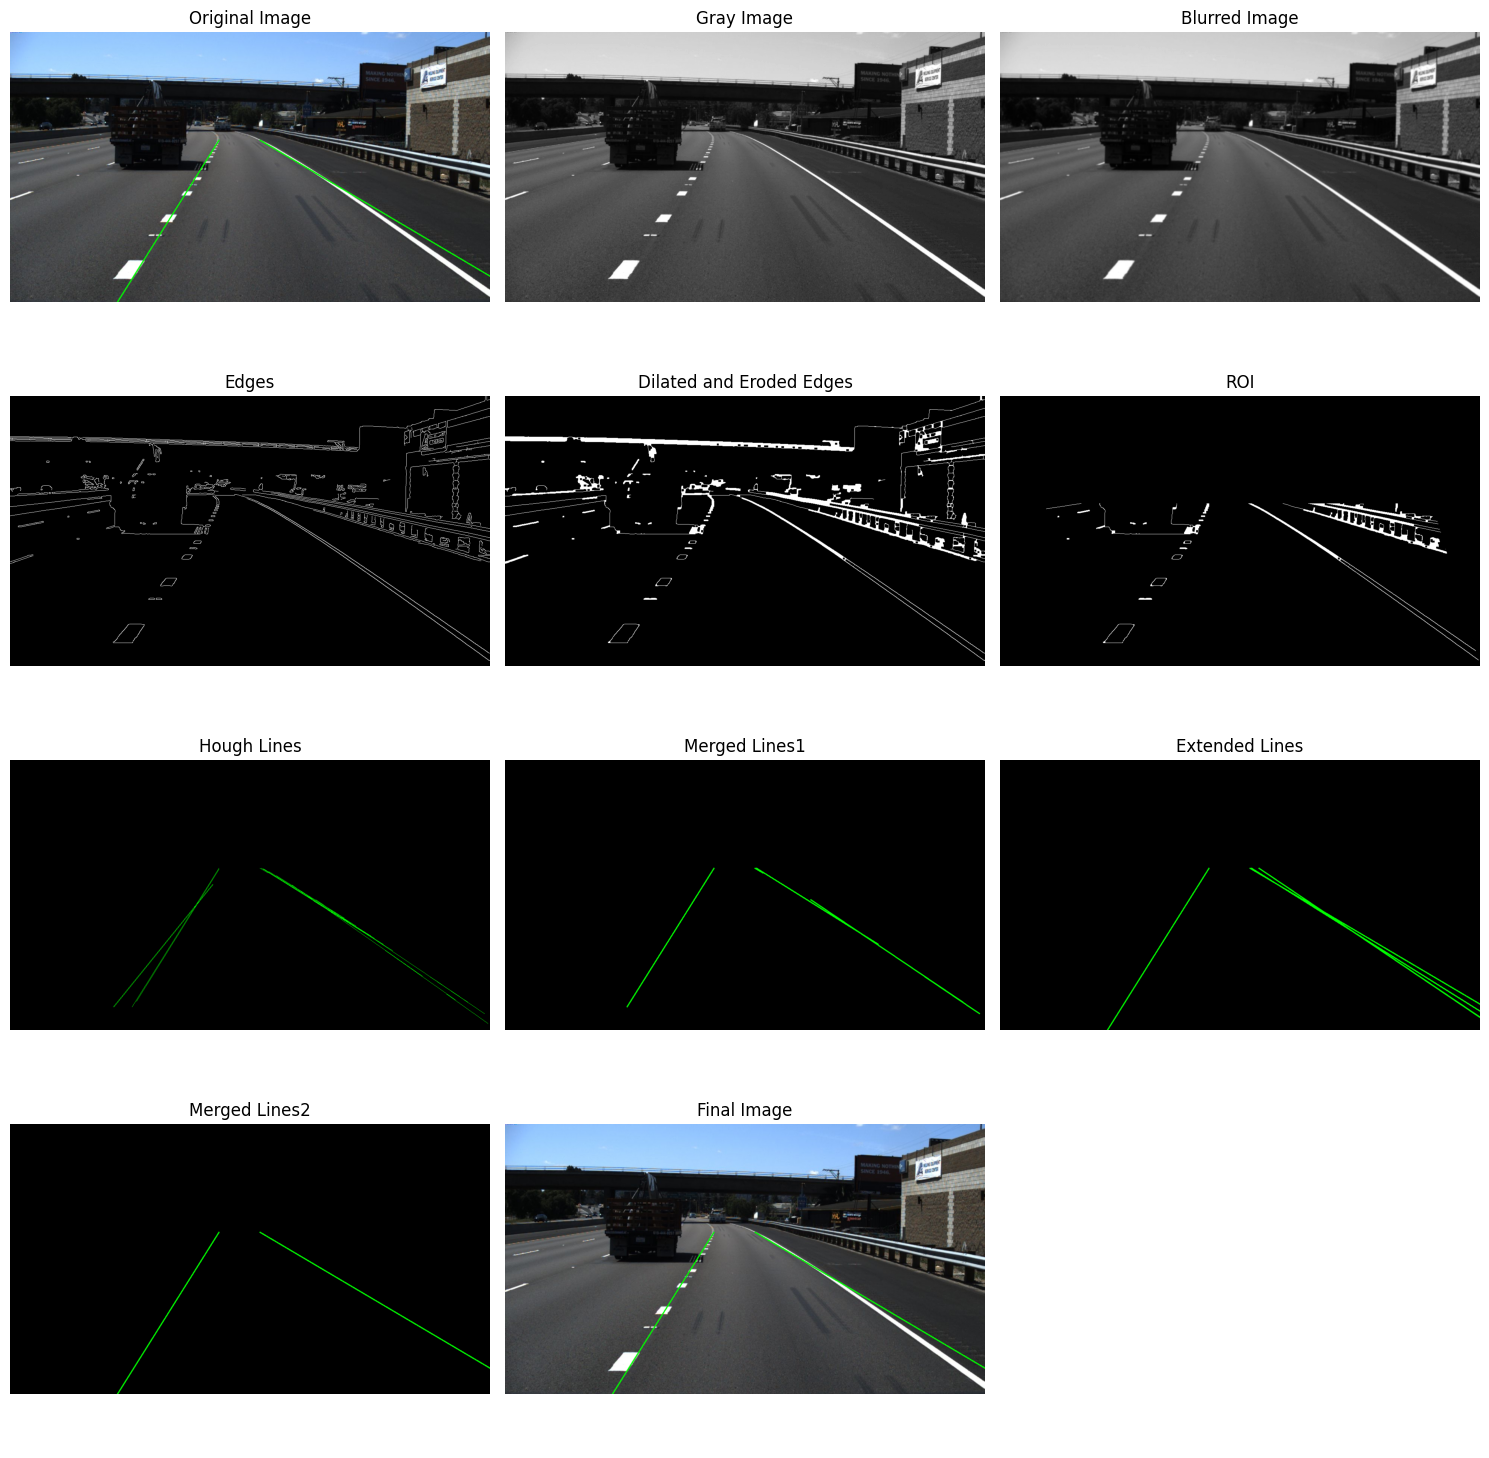

In [60]:
display_pipeline("Test Images/image10.jpg")

### Detect lanes for multiple images

In [61]:
def detect_image_lanes():
    titles = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg", "image5.jpg", "image6.jpg", "image7.jpg", "image8.jpg", "image9.jpg", "image10.jpg"]
    images = [pipeline(f"Test Images/{title}")[-1] for title in titles]

    plot_images(images, titles, 5, 2)

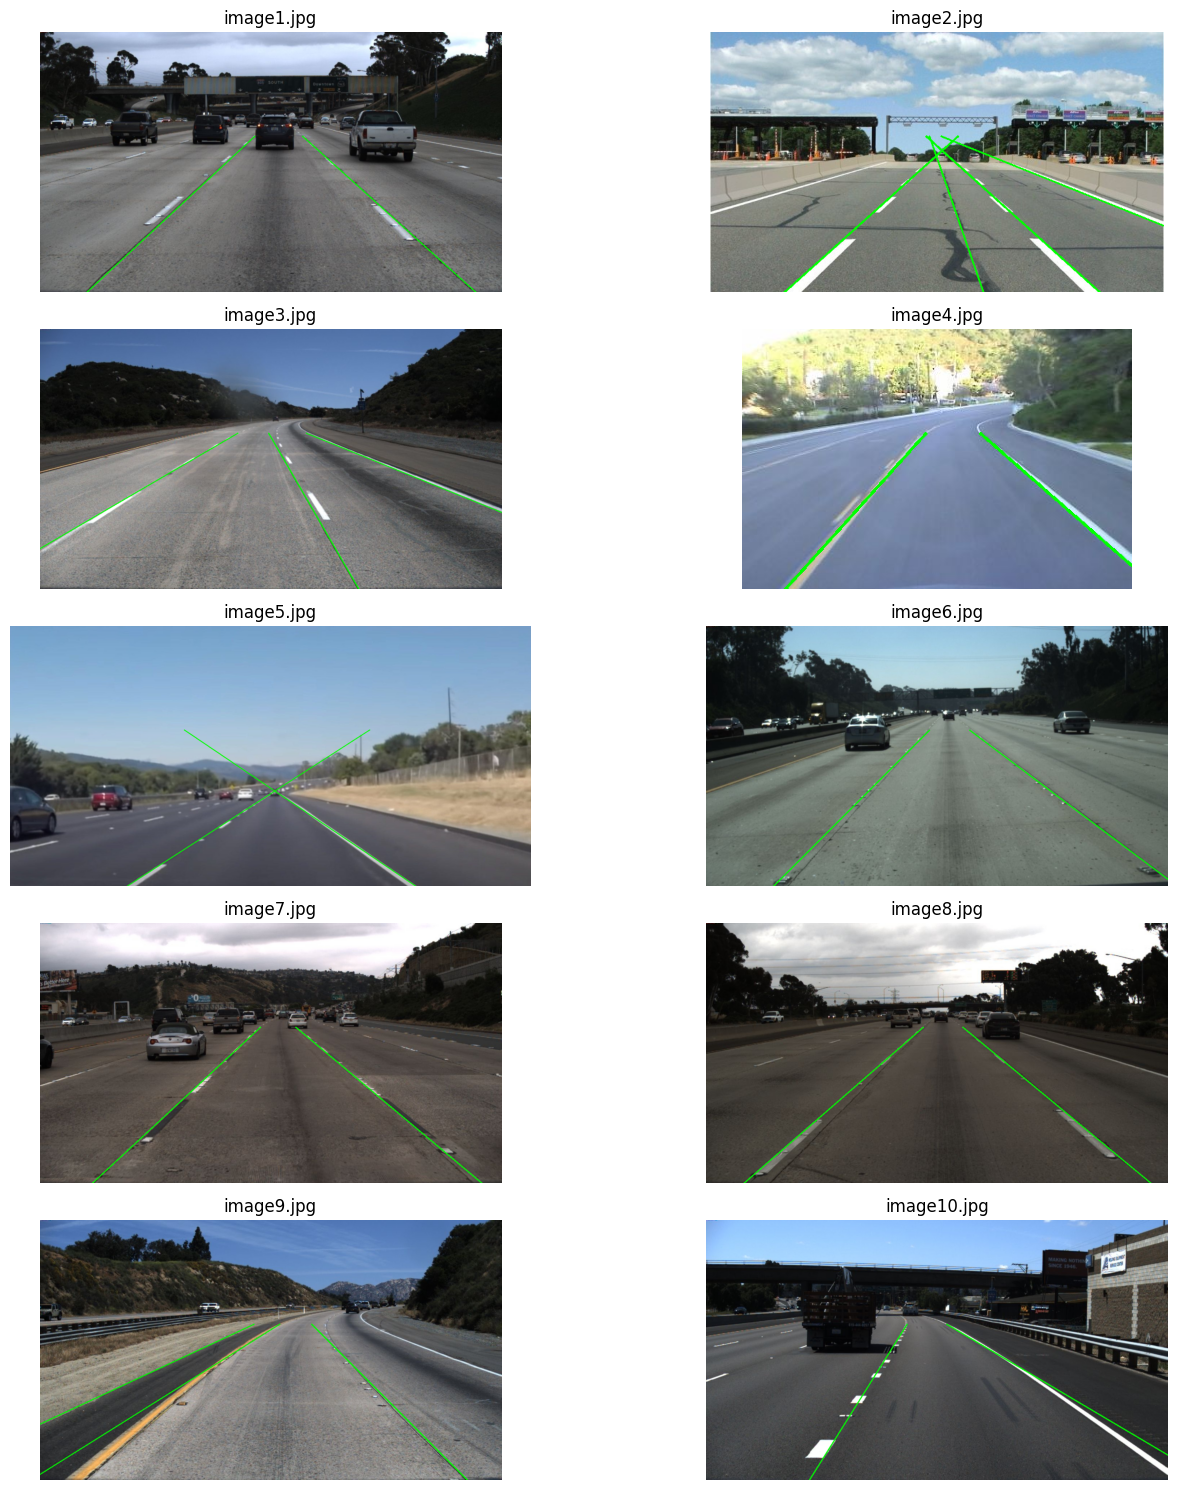

In [62]:
detect_image_lanes()